# Planar data classification with one hidden layer

- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation


## 1 - Packages ##

- testCases provides some test examples to assess the correctness of the functions
- planar_utils provide various useful functions used in this assignment

In [2]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
%matplotlib inline
np.random.seed(1) # set a seed so that the results are consistent

## 2 - Dataset ##

In [3]:
X, Y = load_planar_dataset()

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Goal is to build a model to fit this data. 

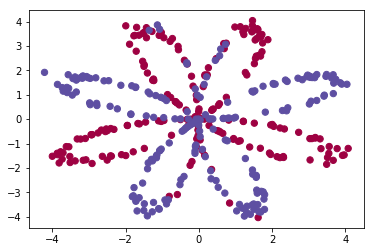

In [4]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y.reshape(400,), s=40, cmap=plt.cm.Spectral);

In [5]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # training set size

## 3 - Simple Logistic Regression

In [6]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T.ravel());

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


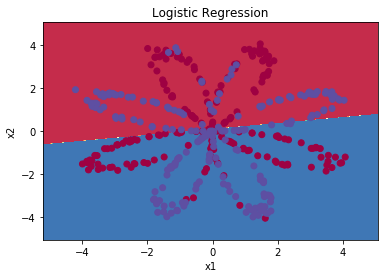

In [7]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well.A neural network will do better.

## 4 - Neural Network model

<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

Build helper functions to compute steps 1-3 and then merge them into one function  `nn_model()`. Once  `nn_model()` is buit and learnt the right parameters, we can make predictions on new data.

### 4.1 - Defining the neural network structure ####

In [8]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)

### 4.2 - Initialize the model's parameters ####

In [10]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) 
    
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    #assert (W1.shape == (n_h, n_x))
    #assert (b1.shape == (n_h, 1))
    #assert (W2.shape == (n_y, n_h))
    #assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 4.3 - The Loop ####

In [12]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.matmul(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.matmul(W2, A1)+ b2
    A2 = sigmoid(Z2)
    
    #assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [14]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (6)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (6)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y) + np.multiply( np.log(1-A2) ,(1-Y)  )
    cost = -1/m*logprobs.sum()
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
    #assert(isinstance(cost, float))
    
    return cost

  
<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

In [17]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2-Y
    dW2 = 1/m*np.matmul(dZ2, A1.T)
    db2 = 1/m*np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.matmul(W2.T, dZ2)*(1-np.power(A1, 2)) 
    dW1 = 1/m*dZ1.dot(X.T)
    db1 = 1/m*np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [19]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    ## END CODE HERE ###
    
    # Update rule for each parameter
    W1 = W1-learning_rate*dW1
    b1 = b1-learning_rate*db1
    W2 = W2-learning_rate*dW2
    b2 = b2-learning_rate*db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in nn_model() ####

In [21]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X,Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
                
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

### 4.5 Predictions
predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

In [23]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2>0.5)
    
    return predictions

Run the model and see how it performs on a planar dataset.

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219454
Cost after iteration 9000: 0.218607


Text(0.5,1,'Decision Boundary for hidden layer size 4')

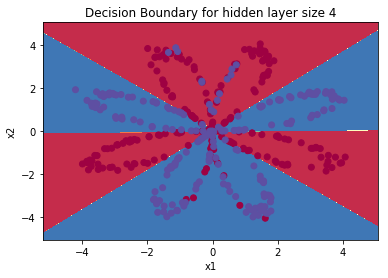

In [25]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [26]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

Now, let's try out several hidden layer sizes.

### 4.6 - Tuning hidden layer size

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.25 %


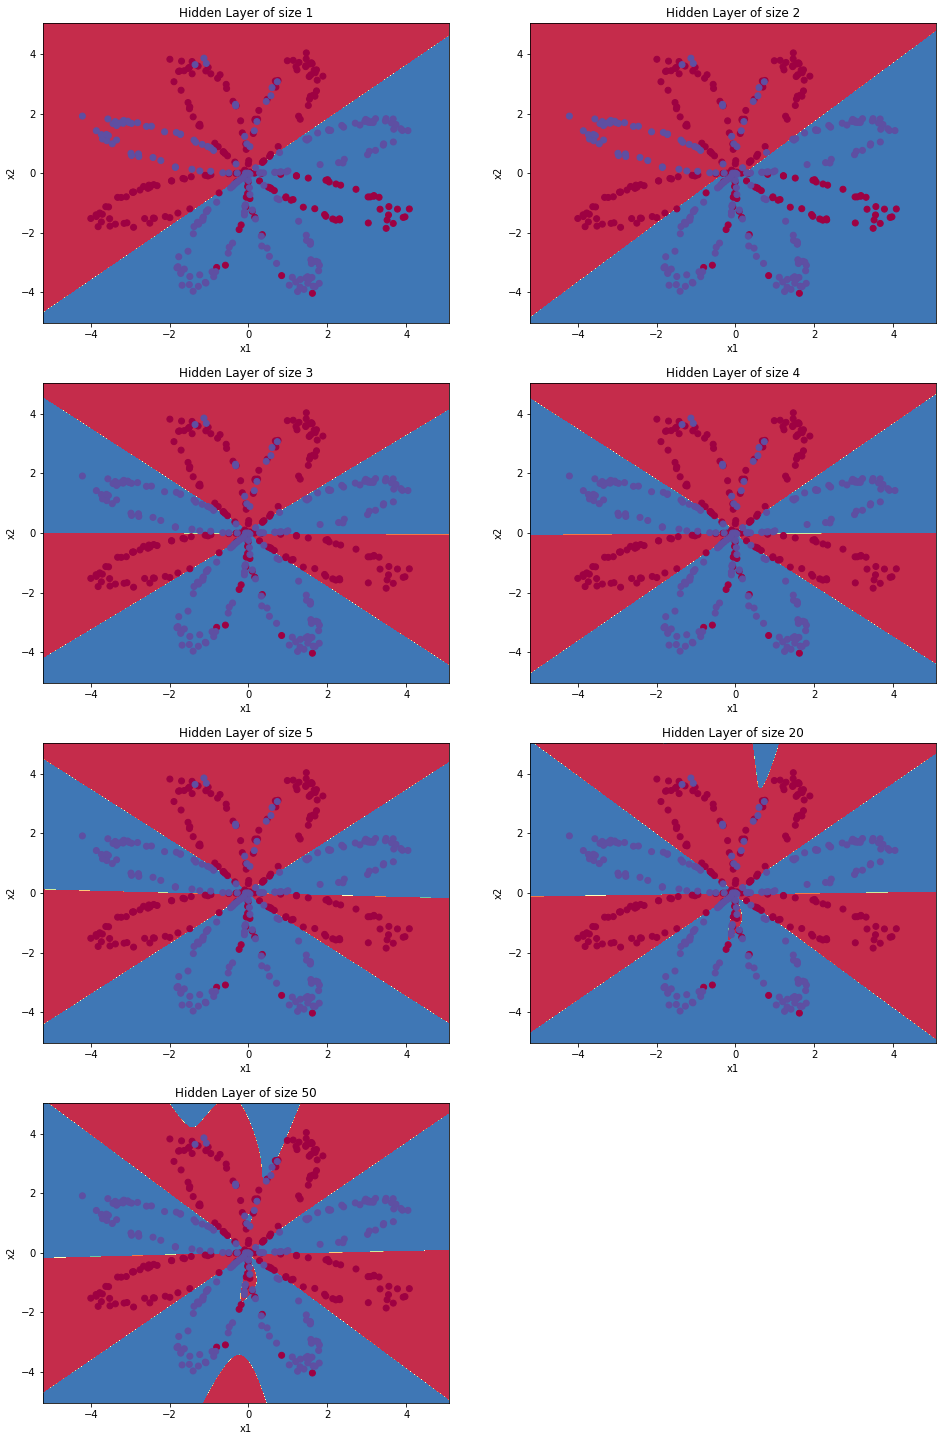

In [27]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticable overfitting.
- n_h = 50 makes overfitting. 